# Assembly of system with multiple domains, variables and numerics

This tutorial demonstrates how a transient problem may be solved in PorePy. We consider an advective-diffusive tracer transport problem for a slightly compressible flow field. The geometry and flow parameters are as in example 2 of this [benchmark study](https://www.sciencedirect.com/science/article/pii/S0309170817300143).


In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
import data.flow_benchmark_2d_geiger_setup as setup


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ivar\anaconda3\envs\idp37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def add_transport_data(gb, parameter_keyword):
    # Method to assign data.
    tol = 1e-4
    kappa_f = 1e-4
    for g, d in gb:
        # Boundary conditions: Dirichlet for left and right side of the domain
        b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        unity = np.ones(g.num_cells)
        empty = np.empty(0)
        if b_faces.size != 0:

            b_face_centers = g.face_centers[:, b_faces]
            b_inflow = b_face_centers[0, :] < tol
            b_outflow = b_face_centers[0, :] > 1-tol

            labels = np.array(["neu"] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)

            bc_val[b_faces[b_inflow]] = 1

        else:
            bc = pp.BoundaryCondition(g) #, empty, empty)
        
        # Porosity
        if g.dim == gb.dim_max():
            porosity = 0.2 * unity
            
            aperture = 1
        else:
            porosity = 0.8 * unity
            aperture = 1e-4
        #porosity = unity.copy()
        specific_volume = np.power(aperture, gb.dim_max() - g.dim)
        diffusivity = kappa_f * np.ones(g.num_cells)
        
        diffusivity = np.ones(g.num_cells) * np.power(kappa_f, g.dim < gb.dim_max()) 
        tensor = pp.SecondOrderTensor(diffusivity * specific_volume)
        # Inherit the aperture assigned for the flow problem
        specified_parameters = {
            "bc": bc,
            "bc_values": bc_val,
            "mass_weight": porosity * specific_volume,
            "second_order_tensor": tensor,
            }
        pp.initialize_default_data(g, d, parameter_keyword, specified_parameters)
        d[pp.PARAMETERS]["flow"].update({"mass_weight": 1e-10 * specific_volume})
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
        
    for e, d in gb.edges():
        mg = d["mortar_grid"]
        specific_volume_h = np.power(1e-4, gb.dim_max() - (mg.dim + 1))
        aperture_l = 1e-4 * np.ones(mg.num_cells)
        
        diffusivity_n = kappa_f / (aperture_l / 2) * specific_volume_h 
        parameters = {
            "normal_diffusivity": diffusivity_n,
            "darcy_flux": np.zeros(mg.num_cells),
        }
        pp.initialize_data(g, d, parameter_keyword, parameters)
    return gb

We start by making a grid bucket, pecifying the keywords for the parameters of the flow and transport problem, respectively. Then we assigne the problem data and visualize the domain.

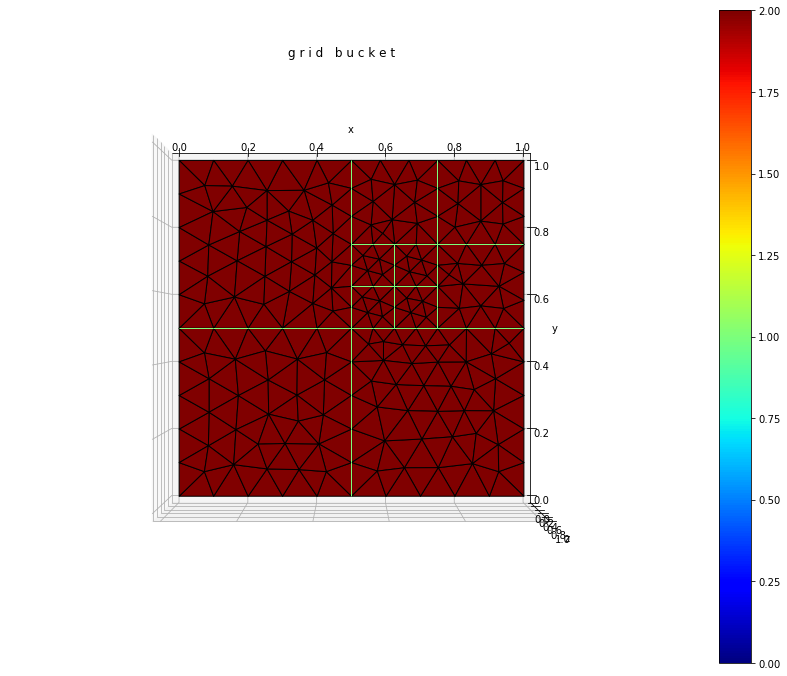

In [3]:
mesh_args = {"mesh_size_frac": .1, "mesh_size_bound": .1}
gb, domain = pp.grid_buckets_2d.benchmark_regular(mesh_args)
fracture_permeability = 1e4
kw_f = 'flow'
kw_t = 'transport'
# Add data - will only add flow data
setup.add_data(gb, domain, fracture_permeability)
# Transport related parameters 
gb = add_transport_data(gb, kw_t)
pp.plot_grid(gb, "dimension", figsize=(15, 12))

Now, we define the variables on subdomains and interfaces and populate the `STATE` and `ITERATE` dictionaries with initial values.

In [4]:
subdomain_pressure_variable = "pressure"
subdomain_tracer_variable = "tracer"
interface_flux_variable = "interface_flux"
interface_advection_variable = "interface_advection"
interface_conduction_variable = "interface_conduction"
# Loop over the nodes in the GridBucket, define primary variables and discretization schemes
for g, d in gb:
    d[pp.PRIMARY_VARIABLES] = {subdomain_pressure_variable: {"cells": 1, "faces": 0},
                               subdomain_tracer_variable: {"cells": 1, "faces": 0}}
    vals = {
        subdomain_pressure_variable: np.zeros(g.num_cells),
        subdomain_tracer_variable: np.zeros(g.num_cells),
    }
    d[pp.STATE] = vals
    d[pp.STATE][pp.ITERATE] = vals.copy()
    
# Loop over the edges in the GridBucket, define primary variables and discretizations
for e, d in gb.edges():
    mg = d["mortar_grid"]
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {interface_flux_variable: {"cells": 1},
                              interface_advection_variable: {"cells": 1},
                              interface_conduction_variable: {"cells": 1},
                              }
    vals = {
        interface_flux_variable: np.zeros(mg.num_cells),
        interface_advection_variable: np.zeros(mg.num_cells),
        interface_conduction_variable: np.zeros(mg.num_cells),
    }
    d[pp.STATE] = vals
    d[pp.STATE][pp.ITERATE] = vals.copy()



 ## Define AD objects
We make a `DofManager` and an `EquationManager` responsible for global degree-of-freedom handling and equation discretization and assembly, respectively. Then, we define discretizations, AD parameters and variables.

In [5]:
dof_manager = pp.DofManager(gb)
eq_manager = pp.ad.EquationManager(gb, dof_manager)

subdomain_list = [g for g, _ in gb.nodes()]
interface_list = [e for e, d in gb.edges()]
subdomain_proj = pp.ad.SubdomainProjections(subdomain_list)
mortar_proj = pp.ad.MortarProjections(
            edges=interface_list, grids=subdomain_list, gb=gb, nd=1
        )
flow = pp.ad.TpfaAd(kw_f, subdomain_list)
conduction = pp.ad.TpfaAd(kw_t, subdomain_list)
advection = pp.ad.UpwindAd(kw_t, subdomain_list)
accumulation_f = pp.ad.MassMatrixAd(kw_f, subdomain_list)
accumulation_t = pp.ad.MassMatrixAd(kw_t, subdomain_list)

interface_flow = pp.ad.RobinCouplingAd(kw_f, interface_list)
interface_advection = pp.ad.UpwindCouplingAd(kw_t, interface_list)
interface_conduction = pp.ad.RobinCouplingAd(kw_t, interface_list)

#Operators
div = pp.ad.Divergence(grids=subdomain_list)
trace = pp.ad.Trace(grids=subdomain_list)
# Parameters
dt = 1e-2
bc_val_f = pp.ad.BoundaryCondition(kw_f, subdomain_list)
bc_val_t = pp.ad.BoundaryCondition(kw_t, subdomain_list)
source_f = pp.ad.ParameterArray(
            param_keyword=kw_f,
            array_keyword="source",
            grids=subdomain_list,
        )
source_t = pp.ad.ParameterArray(
            param_keyword=kw_t,
            array_keyword="source",
            grids=subdomain_list,
        )
# Ad variables
p = eq_manager.merge_variables(
    [(g, subdomain_pressure_variable) for g in subdomain_list]
)
p_prev = p.previous_timestep()
interface_flux = eq_manager.merge_variables(
    [(e, interface_flux_variable) for e in interface_list]
)
t = eq_manager.merge_variables(
    [(g, subdomain_tracer_variable) for g in subdomain_list]
)
t_prev = t.previous_timestep()
advective_interface_flux = eq_manager.merge_variables(
    [(e, interface_advection_variable) for e in interface_list]
)
conductive_interface_flux = eq_manager.merge_variables(
        [(e, interface_conduction_variable) for e in interface_list]
    )


C:\Users\Ivar\OneDrive - RUDEN AS\Dokumenter\GitHub\porepy\src\porepy\grids\mortar_grid.py:664: UserWarning: Is it really meaningful to ask for signs of a one sided mortar grid?
  "Is it really meaningful to ask for signs of a one sided mortar grid?"


In [6]:
flux = (
    flow.flux * p
    + flow.bound_flux * bc_val_f
    + flow.bound_flux * mortar_proj.mortar_to_primary_int * interface_flux
)
flux.set_name("darcy flux")
subdomain_flow_eq = (
    accumulation_f.mass * (p - p_prev) / dt +
    div * flux 
    - mortar_proj.mortar_to_secondary_int * interface_flux
    - source_f
)
p_primary = (
    flow.bound_pressure_cell * p
    + flow.bound_pressure_face
    * mortar_proj.mortar_to_primary_int
    * interface_flux
    + flow.bound_pressure_face * bc_val_f
)
# Project the two pressures to the interface and equate with \lambda
interface_flow_eq = (
    interface_flow.mortar_discr
    * (
        mortar_proj.primary_to_mortar_avg * p_primary
        - mortar_proj.secondary_to_mortar_avg * p
    )
    + interface_flux
)


## Define transport equation
Again, there is one equation on all subdomains. On the interfaces, there are one or two flux equations depending on whether conduction is considered.
term on the nodes ($- \nabla \cdot K \nabla p$) and the coupling term $- \kappa (p_{fracture} - \texttt{tr }p_{matrix})$ on the edges. See parameter_assignment_assembler_setup.ipynb for more detail on how to set up the flow problem.

In [7]:
fluxes = (
    conduction.flux * t
    + flux * ( advection.upwind *  t )
    + conduction.bound_flux * bc_val_t
    - advection.bound_transport_dir * flux * bc_val_t
    - advection.bound_transport_neu * (
        mortar_proj.mortar_to_primary_int * advective_interface_flux
        + bc_val_t)
    + conduction.bound_flux * mortar_proj.mortar_to_primary_int * conductive_interface_flux
)

accumulation_term = (
    accumulation_t.mass * (t - t_prev) 
) / dt
subdomain_transport_eq = (
    accumulation_term
    + div * fluxes
    - mortar_proj.mortar_to_secondary_int * conductive_interface_flux
    - mortar_proj.mortar_to_secondary_int * advective_interface_flux
    - source_t
)
t_primary = (
    conduction.bound_pressure_cell * t
    + conduction.bound_pressure_face
    * mortar_proj.mortar_to_primary_int
    * conductive_interface_flux
    + conduction.bound_pressure_face
    * bc_val_t
)

interface_conduction_eq = (
    interface_conduction.mortar_discr * (
    mortar_proj.primary_to_mortar_avg * t_primary
    - mortar_proj.secondary_to_mortar_avg * t
    )
    + conductive_interface_flux
)
interface_advection_eq = (
    interface_flux
    * (interface_advection.upwind_primary
    * mortar_proj.primary_to_mortar_avg
    * trace.trace
    * t)
    + interface_flux
    * (interface_advection.upwind_secondary
    * mortar_proj.secondary_to_mortar_avg
    * t)
    - advective_interface_flux
)
equations = {
    "Subdomain flow": subdomain_flow_eq,
    "Subdomain transport": subdomain_transport_eq,
    "Interface flow": interface_flow_eq,
    "Interface advection": interface_advection_eq,
    "Interface conduction": interface_conduction_eq,
}
eq_manager.equations.update(equations)

Discretize, assemble and solve the linear system in a time loop. We also have to update the `STATE` and `ITERATE` and  back-compute the fluid fluxes (which are not primary variables in the primal formulation of the finite volume scheme used) from the pressure solution. 
We plot the tracer distribution at each time step and the final pressure. The tracer enters from the right boundary, and is transported more quickly through the fractures than the matrix.

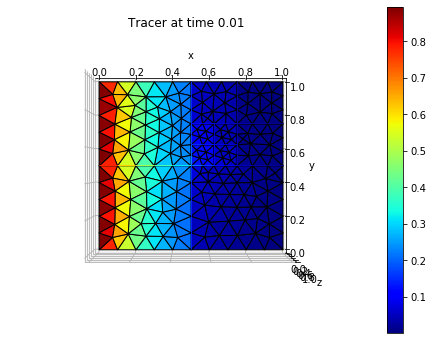

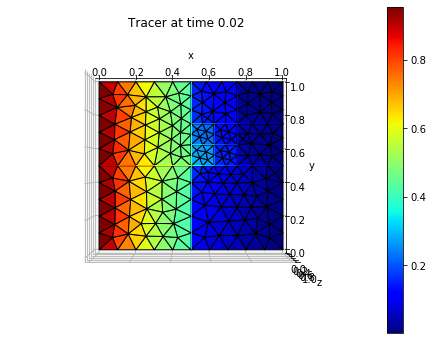

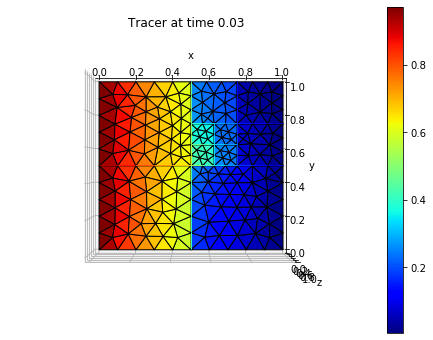

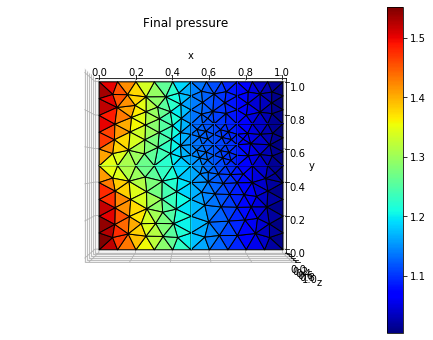

In [8]:
# Discretize all terms
eq_manager.discretize(gb)
time = dt
final_time = 3e-2

sol_prev = np.zeros(dof_manager.num_dofs())
nonlinear_tolerance = 1e-5
while time <= final_time:
    converged = False
    while not converged:
        # Rediscretize advection if flow field is transient
        
        pp.fvutils.compute_darcy_flux(gb, keyword_store=kw_t ,lam_name=interface_flux_variable, from_iterate=True)
        eq_manager.discretize(gb)
        # Iteration
        A, b = eq_manager.assemble()
        sol = sps.linalg.spsolve(A, b)
        error = np.linalg.norm(sol) / np.linalg.norm(np.ones(sol.size))
        error_inf = np.linalg.norm(sol, np.inf)
        sol_prev = sol.copy()#dof_manager.distribute to iterate
        dof_manager.distribute_variable(
            values=sol, additive=True, to_iterate=True
        )
        if error < nonlinear_tolerance:
            converged = True        
            
    solution = dof_manager.assemble_variable(from_iterate=True)
    dof_manager.distribute_variable(values=solution, additive=False)
    pp.plot_grid(gb, subdomain_tracer_variable, figsize=(8, 6), title=f"Tracer at time {time}")
    time += dt

    

folder = "tracer_transport"
exporter = pp.Exporter(gb, "flow", folder_name=folder)
pp.plot_grid(gb, subdomain_pressure_variable, figsize=(8, 6), title="Final pressure")
